# Visual-language assistant with MiniCPM-V2 and OpenVINO

MiniCPM-V 2 is a strong multimodal large language model for efficient end-side deployment. The model is built based on SigLip-400M and MiniCPM-2.4B, connected by a perceiver resampler. MiniCPM-V 2.0 has several notable features:
* **Outperforming many popular models on many benchmarks** (including OCRBench, TextVQA, MME, MMB, MathVista, etc). Strong OCR capability, achieving comparable performance to Gemini Pro in scene-text understanding.
* **Trustworthy Behavior**. LLMs are known for suffering from hallucination, often generating text not factually grounded in images. MiniCPM-V 2.0 is the first end-side LLM aligned via multimodal RLHF for trustworthy behavior (using the recent [RLHF-V](https://rlhf-v.github.io/) [CVPR'24] series technique). This allows the model to match GPT-4V in preventing hallucinations on Object HalBench.
* **High-Resolution Images at Any Aspect Raito.** MiniCPM-V 2.0 can accept 1.8 million pixels (e.g., 1344x1344) images at any aspect ratio. This enables better perception of fine-grained visual information such as small objects and optical characters, which is achieved via a recent technique from [LLaVA-UHD](https://arxiv.org/pdf/2403.11703).
* **High Efficiency.** For visual encoding, model compresses the image representations into much fewer tokens via a perceiver resampler. This allows MiniCPM-V 2.0 to operate with favorable memory cost and speed during inference even when dealing with high-resolution images.
* **Bilingual Support.** MiniCPM-V 2.0 supports strong bilingual multimodal capabilities in both English and Chinese. This is enabled by generalizing multimodal capabilities across languages, a technique from [VisCPM](https://arxiv.org/abs/2308.12038)[ICLR'24].

In this tutorial we consider how to convert and optimize MiniCPM-V2 model for creating multimodal chatbot. Additionally, we demonstrate how to apply stateful transformation on LLM part and model optimization techniques like weights compression using [NNCF](https://github.com/openvinotoolkit/nncf)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Download PyTorch model](#Download-PyTorch-model)
- [Convert model to OpenVINO Intermediate Representation](#Convert-model-to-OpenVINO-Intermediate-Representation)
    - [Text embeddings](#Text-embeddings)
    - [Language Model](#Language-Model)
    - [Compress Language Model Weights to 4 bits](#Compress-Language-Model-Weights-to-4-bits)
    - [Image Encoder](#Image-Encoder)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select device](#Select-device)
    - [Select model variant](#Select-model-variant)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](../../README.md).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "torch>=2.1" "torchvision" "timm" "transformers>=4.40" "Pillow" "gradio>=4.19" "tqdm" "sentencepiece" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2024.2.0" "nncf>=2.11.0"

## Download PyTorch model
[back to top ⬆️](#Table-of-contents:)

In [2]:
from transformers import AutoModel, AutoTokenizer
from pathlib import Path

model_dir = Path("model")
text_emb_path = model_dir / "language_model/embed_tokens.xml"
image_encoder_path = model_dir / "image_encoder.xml"
llm_path = model_dir / "language_model/language_model.xml"

model = None

if not all([text_emb_path.exists(), image_encoder_path.exists(), llm_path.exists()]):
    model = AutoModel.from_pretrained("openbmb/MiniCPM-V-2", trust_remote_code=True)
    model.eval()
    model.config.save_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained("openbmb/MiniCPM-V-2", trust_remote_code=True)
    tokenizer.save_pretrained(model_dir)

## Convert model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

MiniCPM-V2 is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

The inference flow has difference on first step and for the next. On the first step, model accept preprocessed input instruction and image, that transformed to the unified embedding space using `input_embedding` and `image_encoder` models, after that `language model`, LLM-based part of model, runs on input embeddings to predict probability of next generated tokens. On the next step, `language_model` accepts only next token id selected based on sampling strategy and processed by `input_embedding` model and cached attention key and values.  Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation).

To sum up above, model consists of 3 parts:

* **Image Encoder** for encoding input images into embedding space. It includes SigLIP model and Resampler.
* **Input Embedding** for conversion input text tokens into embedding space
* **Language Model** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models.

Let's convert each model part.

### Text embeddings
[back to top ⬆️](#Table-of-contents:)

In LLMs, input embedding is a part of language model, but for multimodal case, the first step hidden state produced by this model part should be integrated with image embeddings into common embedding space. For ability to reuse this model part and avoid introduction of llm model instance, we will use it separately.

In [3]:
import openvino as ov
import torch
import gc


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


if not text_emb_path.exists():
    ov_model = ov.convert_model(model.llm.model.embed_tokens, example_input=torch.ones([1, 10], dtype=torch.long))

    ov.save_model(ov_model, text_emb_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect()

### Language Model
[back to top ⬆️](#Table-of-contents:)

Language Model is responsible for generation answer in MiniCPM-V. This part is very similar to standard LLM for text generation. Our model uses [MiniCPM-2.4B](https://github.com/OpenBMB/MiniCPM/) as base LLM.
To optimize the generation process and use memory more efficiently, HuggingFace transformers API provides a mechanism for caching model state externally using `use_cache=True` parameter and `past_key_values` argument in inputs and outputs. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. With this option, the model gets the previous step's hidden states (cached attention keys and values) as input and additionally provides hidden states for the current step as output. It means for all next iterations, it is enough to provide only a new token obtained from the previous step and cached key values to get the next token prediction.

With increasing model size like in modern LLMs, we also can note an increase in the number of attention blocks and size past key values tensors respectively. The strategy for handling cache state as model inputs and outputs in the inference cycle may become a bottleneck for memory-bounded systems, especially with processing long input sequences, for example in a chatbot scenario. OpenVINO suggests a transformation that removes inputs and corresponding outputs with cache tensors from the model keeping cache handling logic inside the model. Such models are also called stateful. A stateful model is a model that implicitly preserves data between two consecutive inference calls. The tensors saved from one run are kept in an internal memory buffer called a `state` or a `variable` and may be passed to the next run, while never being exposed as model output. Hiding the cache enables storing and updating the cache values in a more device-friendly representation. It helps to reduce memory consumption and additionally optimize model performance. More details about stateful models and working with state can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/running-inference/stateful-models.html).

In [4]:
from typing import Optional, Tuple, List
from openvino.runtime import opset13
import numpy as np


def model_has_state(ov_model: ov.Model):
    # TODO: Provide a better way based on the variables availability, but OV Python API doesn't expose required methods
    return len(ov_model.get_sinks()) > 0


def model_has_input_output_name(ov_model: ov.Model, name: str):
    """
    Helper function for checking that model has specified input or output name

    Parameters:
      ov_model (ov.Model):   # TODO: Can we derive the dimensions from the model topology?
      name (str):
          name of input or output

    Returns:
      True if input or output with requested name exists else False
    """
    return name in sum([list(t.get_names()) for t in ov_model.inputs + ov_model.outputs], [])


def fuse_cache_reorder(
    ov_model: ov.Model,
    not_kv_inputs: List[str],
    key_value_input_names: List[str],
    gather_dim: int,
):
    """
    Fuses reored_cache during generate cycle into ov.Model. Used with stateful models, because we can not modify model state directly.

    Adds a new beam_idx parameter and Gather op per each kv-cache input in a given model.
    Should be run before make_stateful. Implements optimumum's _reorder_cache
    inside the model in the beginning of each iteration.
    Gather works along given gather_dim dimension that may vary from model to model.
    KV-cache inputs are identified based on names in key_value_input_names.
    Append the new beam_idx parameter to not_kv_inputs.

    Parameters:
      ov_model (`ov.Model`):
          openvino model for processing
      not_kv_inputs (`List[str]`):
          list of input nodes in model that not related to past key values
      key_value_input_names (`List[str]`):
          list of names for key value input layers
      gather_dim (int):
          dimension for gathering cache during reorder pass
    """

    if model_has_input_output_name(ov_model, "beam_idx"):
        raise ValueError("Model already has fused cache")
    input_batch = ov_model.input("inputs_embeds").get_partial_shape()[0]
    beam_idx = opset13.parameter(name="beam_idx", dtype=ov.Type.i32, shape=ov.PartialShape([input_batch]))
    beam_idx.output(0).get_tensor().add_names({"beam_idx"})  # why list is not accepted?
    ov_model.add_parameters([beam_idx])
    not_kv_inputs.append(ov_model.inputs[-1])
    # Go over all cache parameters and fuse _reorder_cache with indices provided by the new parameter beam_idx
    for input_name in key_value_input_names:
        parameter_output_port = ov_model.input(input_name)
        consumers = parameter_output_port.get_target_inputs()
        gather = opset13.gather(parameter_output_port, beam_idx, opset13.constant(gather_dim))
        for consumer in consumers:
            consumer.replace_source_output(gather.output(0))
    ov_model.validate_nodes_and_infer_types()


def build_state_initializer(ov_model: ov.Model, batch_dim: int):
    """
    Build initialization ShapeOf Expression for all ReadValue ops

    Parameters:
      ov_model (ov.Model):
          openvino model
      batch_dim (int):
          index of dimension corresponding to batch size
    """
    input_ids = ov_model.input("inputs_embeds")
    batch = opset13.gather(
        opset13.shape_of(input_ids, output_type="i64"),
        opset13.constant([0]),
        opset13.constant(0),
    )
    for op in ov_model.get_ops():
        if op.get_type_name() == "ReadValue":
            dims = [dim.min_length for dim in list(op.get_output_partial_shape(0))]
            dims[batch_dim] = batch
            dims = [(opset13.constant(np.array([dim], dtype=np.int64)) if isinstance(dim, int) else dim) for dim in dims]
            shape = opset13.concat(dims, axis=0)
            broadcast = opset13.broadcast(opset13.constant(0.0, dtype=op.get_output_element_type(0)), shape)
            op.set_arguments([broadcast])
    ov_model.validate_nodes_and_infer_types()


def make_stateful(
    ov_model: ov.Model,
    not_kv_inputs: List[str],
    key_value_input_names: List[str],
    key_value_output_names: List[str],
    batch_dim: int,
    num_attention_heads: int,
    num_beams_and_batch: int = None,
):
    """
    Hides kv-cache inputs and outputs inside the model as variables.

    Parameters:
        ov_model (ov.Model):
            openvino model
        not_kv_inputs (`List[str]`):
            list of input nodes in model that not related to past key values
        key_value_input_names (`List[str]`):
            list of names for key value input layers
        key_value_output_names (`List[str]`):
            list of names for key value input layers
        batch_dim (int):
            index of batch dimension in key value layers
        num_attention_heads (int):
            number of attention heads for batch dimension initialization
        num_beams_an_batch (int):
            precalculated number of beams and batch for shapes initialization
    """
    from openvino._offline_transformations import apply_make_stateful_transformation

    input_output_map = {}

    if num_beams_and_batch is not None:
        # Set batch size for input_ids and attention mask to avoid dynamic dimension got propagated from the end of the model back to ReadValue
        for input in not_kv_inputs:
            shape = input.get_partial_shape()
            if shape.rank.get_length() <= 2:  # == 1 for beam_index
                shape[0] = num_beams_and_batch
                input.get_node().set_partial_shape(shape)
    for kv_name_pair in zip(key_value_input_names, key_value_output_names):
        input_output_map[kv_name_pair[0]] = kv_name_pair[1]
        if num_beams_and_batch is not None:
            input = ov_model.input(kv_name_pair[0])
            shape = input.get_partial_shape()
            shape[batch_dim] = num_beams_and_batch * num_attention_heads
            input.get_node().set_partial_shape(shape)

    if num_beams_and_batch is not None:
        # Re-validation model if shapes are altered above
        ov_model.validate_nodes_and_infer_types()

    apply_make_stateful_transformation(ov_model, input_output_map)
    if num_beams_and_batch is None:
        build_state_initializer(ov_model, batch_dim)


def patch_stateful(ov_model):
    key_value_input_names = [key.get_any_name() for key in ov_model.inputs[2:-1]]
    key_value_output_names = [key.get_any_name() for key in ov_model.outputs[1:]]
    not_kv_inputs = [input for input in ov_model.inputs if not any(name in key_value_input_names for name in input.get_names())]
    if not key_value_input_names or not key_value_output_names:
        return
    batch_dim = 0
    num_attention_heads = 1

    fuse_cache_reorder(ov_model, not_kv_inputs, key_value_input_names, batch_dim)
    make_stateful(
        ov_model,
        not_kv_inputs,
        key_value_input_names,
        key_value_output_names,
        batch_dim,
        num_attention_heads,
        None,
    )

In [5]:
import types
from transformers.cache_utils import Cache, DynamicCache
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from typing import Union


def forward_wrap(self, attention_mask, position_ids, past_key_values, inputs_embeds):
    result = self._orig_forward(
        input_ids=None, attention_mask=attention_mask, position_ids=position_ids, past_key_values=past_key_values, inputs_embeds=inputs_embeds
    )
    return tuple(result.values())


def _update_causal_mask(
    self,
    attention_mask: torch.Tensor,
    input_tensor: torch.Tensor,
    cache_position: torch.Tensor,
    past_key_values: Cache,
    output_attentions: bool,
):
    past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0

    dtype, device = input_tensor.dtype, input_tensor.device
    min_dtype = torch.finfo(dtype).min
    sequence_length = input_tensor.shape[1]

    target_length = attention_mask.shape[-1] if isinstance(attention_mask, torch.Tensor) else past_seen_tokens + sequence_length + 1

    if attention_mask is not None and attention_mask.dim() == 4:
        # in this case we assume that the mask comes already in inverted form and requires no inversion or slicing
        if attention_mask.max() != 0:
            raise ValueError("Custom 4D attention mask should be passed in inverted form with max==0`")
        causal_mask = attention_mask
    else:
        causal_mask = torch.full((sequence_length, target_length), fill_value=min_dtype, dtype=dtype, device=device)
        if sequence_length != 1:
            causal_mask = torch.triu(causal_mask, diagonal=1)
        causal_mask *= torch.arange(target_length, device=device) > cache_position.reshape(-1, 1)
        causal_mask = causal_mask[None, None, :, :].expand(input_tensor.shape[0], 1, -1, -1)
        if attention_mask is not None:
            causal_mask = causal_mask.clone()  # copy to contiguous memory for in-place edit
            mask_length = attention_mask.shape[-1]
            padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :]
            padding_mask = padding_mask == 0
            causal_mask[:, :, :, :mask_length] = causal_mask[:, :, :, :mask_length].masked_fill(padding_mask, min_dtype)

    return causal_mask


def _model_forward(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[List[torch.FloatTensor]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, BaseModelOutputWithPast]:
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    use_cache = use_cache if use_cache is not None else self.config.use_cache

    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    # retrieve input_ids and inputs_embeds
    if input_ids is not None and inputs_embeds is not None:
        raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
    elif input_ids is not None:
        batch_size, seq_length = input_ids.shape[:2]
    elif inputs_embeds is not None:
        batch_size, seq_length = inputs_embeds.shape[:2]
    else:
        raise ValueError("You have to specify either input_ids or inputs_embeds")

    past_key_values_length = 0
    if use_cache:
        use_legacy_cache = not isinstance(past_key_values, Cache)
        if use_legacy_cache:
            past_key_values = DynamicCache.from_legacy_cache(past_key_values)
        past_key_values_length = past_key_values.get_usable_length(seq_length)

    if position_ids is None:
        device = input_ids.device if input_ids is not None else inputs_embeds.device
        position_ids = torch.arange(
            past_key_values_length,
            seq_length + past_key_values_length,
            dtype=torch.long,
            device=device,
        )
        position_ids = position_ids.unsqueeze(0)

    if inputs_embeds is None:
        inputs_embeds = self.embed_tokens(input_ids) * self.config.scale_emb
    if self._use_sdpa and not output_attentions:
        # output_attentions=True can not be supported when using SDPA, and we fall back on
        # the manual implementation that requires a 4D causal mask in all cases.
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        cache_position = torch.arange(past_seen_tokens, past_seen_tokens + inputs_embeds.shape[1], device=inputs_embeds.device)
        attention_mask = self._update_causal_mask(attention_mask, inputs_embeds, cache_position, past_key_values, output_attentions)
    else:
        # 4d mask is passed through the layers
        attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask,
            (batch_size, seq_length),
            inputs_embeds,
            past_key_values_length,
        )

    # embed positions
    hidden_states = inputs_embeds

    # decoder layers
    all_hidden_states = () if output_hidden_states else None
    all_self_attns = () if output_attentions else None
    next_decoder_cache = None

    for decoder_layer in self.layers:
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        layer_outputs = decoder_layer(
            hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_values,
            output_attentions=output_attentions,
            use_cache=use_cache,
        )

        hidden_states = layer_outputs[0]

        if use_cache:
            next_decoder_cache = layer_outputs[2 if output_attentions else 1]

        if output_attentions:
            all_self_attns += (layer_outputs[1],)

    hidden_states = self.norm(hidden_states)

    # add hidden states from the last decoder layer
    if output_hidden_states:
        all_hidden_states += (hidden_states,)

    next_cache = None
    if use_cache:
        next_cache = next_decoder_cache.to_legacy_cache() if use_legacy_cache else next_decoder_cache
    if not return_dict:
        return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_self_attns] if v is not None)
    return BaseModelOutputWithPast(
        last_hidden_state=hidden_states,
        past_key_values=next_cache,
        hidden_states=all_hidden_states,
        attentions=all_self_attns,
    )


if not llm_path.exists():
    model.llm.model.forward = types.MethodType(_model_forward, model.llm.model)
    model.llm.model._update_causal_mask = types.MethodType(_update_causal_mask, model.llm.model)
    llm_input = torch.zeros([2, 2, 2304])
    pkv = model.llm(inputs_embeds=llm_input, attention_mask=torch.ones((2, 2), dtype=torch.int64))[1]
    model_inputs = ["attention_mask", "position_ids"]
    model_outputs = ["logits"]
    for idx in range(len(pkv)):
        model_inputs.extend([f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"])
        model_outputs.extend([f"present.{idx}.key", f"present.{idx}.value"])
    model_inputs.append("inputs_embeds")
    model.llm._orig_forward = model.llm.forward

    model.llm.forward = types.MethodType(forward_wrap, model.llm)
    position_ids = torch.tensor([[2, 3], [2, 3]])
    ov_model = ov.convert_model(
        model.llm,
        example_input={
            "inputs_embeds": llm_input,
            "attention_mask": torch.ones([2, 4], dtype=torch.int64),
            "past_key_values": pkv,
            "position_ids": position_ids,
        },
    )

    for input, input_name in zip(ov_model.inputs, model_inputs):
        input.get_tensor().set_names({input_name})

    for output, output_name in zip(ov_model.outputs, model_outputs):
        output.get_tensor().set_names({output_name})
    patch_stateful(ov_model)

    ov.save_model(ov_model, llm_path)
    model.llm.config.save_pretrained(llm_path.parent)
    del ov_model
    cleanup_torchscript_cache()
    del model.llm
    gc.collect()

### Compress Language Model Weights to 4 bits
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

> **Note:** weights compression process may require additional time and memory for performing. You can disable it using widget below:

In [6]:
import ipywidgets as widgets

to_compress_weights = widgets.Checkbox(
    value=True,
    description="Weights Compression",
    disabled=False,
)

to_compress_weights

Checkbox(value=True, description='Weights Compression')

In [7]:
import nncf
import shutil

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_SYM,
    "group_size": 64,
    "ratio": 0.6,
}


core = ov.Core()
llm_int4_path = llm_path.parent.parent / "language_model_int4" / llm_path.name
if to_compress_weights.value and not llm_int4_path.exists():
    ov_model = core.read_model(llm_path)
    ov_compressed_model = nncf.compress_weights(ov_model, **compression_configuration)
    ov.save_model(ov_compressed_model, llm_int4_path)
    del ov_compressed_model
    del ov_model
    gc.collect()
    shutil.copy(text_emb_path, llm_int4_path.parent / text_emb_path.name)
    shutil.copy(text_emb_path.with_suffix(".bin"), llm_int4_path.parent / text_emb_path.with_suffix(".bin").name)
    shutil.copy(llm_path.parent / "config.json", llm_int4_path.parent / "config.json")

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### Image Encoder
[back to top ⬆️](#Table-of-contents:)

Image Encoder is represented in MiniCPM-V by pretrained [SigLIP](https://huggingface.co/google/siglip-so400m-patch14-384) model. Additionally, MiniCPM uses perceiver resampler that compresses the image representations. We will combine them together into one model.

In [8]:
class ImageEncoder(torch.nn.Module):
    def __init__(self, vpm, resampler):
        super().__init__()
        self.vpm = vpm
        self.resampler = resampler

    def forward(self, pixel_values, tgt_size):
        vision_embedding = self.vpm.forward_features(pixel_values)
        if hasattr(self.vpm, "num_prefix_tokens") and self.vpm.num_prefix_tokens > 0:
            vision_embedding = vision_embedding[:, self.vpm.num_prefix_tokens :]
        if self.resampler.adaptive:
            pos_embed = (
                self.get_2d_sincos_pos_embed(self.resampler.embed_dim, tgt_size).float().to(device=vision_embedding.device, dtype=vision_embedding.dtype)
            )
        else:
            pos_embed = self.get_abs_pos(self.resampler.pos_embed, tgt_size)

        x = self.resampler.kv_proj(vision_embedding)
        x = self.resampler.ln_kv(x).permute(1, 0, 2)

        N = x.shape[1]
        q = self.resampler.ln_q(self.resampler.query)
        out = self.resampler.attn(self.resampler._repeat(q, N) + self.resampler.pos_embed.unsqueeze(1), x + pos_embed.unsqueeze(1), x, attn_mask=None)[0]
        x = out.permute(1, 0, 2)

        x = self.resampler.ln_post(x)
        x = x @ self.resampler.proj
        return x

    def get_2d_sincos_pos_embed(self, embed_dim, grid_size, cls_token=False):
        """
        grid_size: int of the grid height and width
        return:
        pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
        """

        grid_h_size, grid_w_size = grid_size[0], grid_size[1]

        grid_h = torch.arange(grid_h_size, dtype=torch.float32)
        grid_w = torch.arange(grid_w_size, dtype=torch.float32)
        grid = torch.meshgrid(grid_w, grid_h)  # here w goes first
        grid = torch.stack(grid, dim=0)

        grid = grid.reshape([2, 1, grid_h.shape[0], grid_w.shape[0]])
        pos_embed = self.get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
        if cls_token:
            pos_embed = torch.cat([torch.zeros([1, embed_dim]), pos_embed], dim=0)
        return pos_embed

    def get_2d_sincos_pos_embed_from_grid(self, embed_dim, grid):
        # use half of dimensions to encode grid_h
        emb_h = self.get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
        emb_w = self.get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

        emb = torch.cat([emb_h, emb_w], dim=1)  # (H*W, D)
        return emb

    def get_1d_sincos_pos_embed_from_grid(self, embed_dim, pos):
        """
        embed_dim: output dimension for each position
        pos: a list of positions to be encoded: size (M,)
        out: (M, D)
        """
        assert embed_dim % 2 == 0
        omega = torch.arange(embed_dim // 2, dtype=torch.float32)
        omega /= embed_dim / 2.0
        omega = 1.0 / 10000**omega  # (D/2,)

        pos = pos.reshape(-1)  # (M,)
        out = torch.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

        emb_sin = torch.sin(out)  # (M, D/2)
        emb_cos = torch.cos(out)  # (M, D/2)

        emb = torch.cat([emb_sin, emb_cos], axis=1)  # (M, D)
        return emb


if not image_encoder_path.exists():
    image_encoder = ImageEncoder(model.vpm, model.resampler)
    ov_model = ov.convert_model(image_encoder, example_input=[torch.ones([1, 3, 448, 448]), torch.tensor([32, 32], dtype=torch.int32)])
    ov.save_model(ov_model, image_encoder_path)
    del ov_model
    cleanup_torchscript_cache()

del model
gc.collect()

3

## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/2727402e-3697-442e-beca-26b149967c84)

As discussed, the model comprises Image Encoder and LLM (with separated text embedding part) that generates answer. Let's define LLM inference class that will represent generation cycle, It is based on [HuggingFace Transformers `GenerationMixin`](https://huggingface.co/docs/transformers/main_classes/text_generation) and looks similar to [Optimum Intel](https://huggingface.co/docs/optimum/intel/index)`OVModelForCausalLM`that is used for LLM inference.

In [9]:
from transformers.generation import GenerationMixin
from transformers import AutoConfig, GenerationConfig

core = ov.Core()


class OvModelForCausalLMWithEmb(GenerationMixin):
    def __init__(self, model_dir, device="CPU", ov_config=None, compile=True) -> None:
        self._supports_cache_class = False
        self.config = AutoConfig.from_pretrained(model_dir, trust_remote_code=True)
        self.config.is_decoder = True
        self.config.is_encoder_decoder = False
        self.generation_config = GenerationConfig.from_model_config(self.config)
        model_dir = Path(model_dir)
        self.model = core.read_model(model_dir / "language_model.xml")
        self.token_emb = core.read_model(model_dir / "embed_tokens.xml")
        self.request = None
        self.token_emb_request = None
        self._device = device.upper()
        self.device = torch.device("cpu")
        self.ov_config = ov_config
        self.next_beam_idx = None
        self._past_length = None
        self.input_names = [input_t.get_any_name() for input_t in self.model.inputs]
        self.main_input_name = "input_ids"
        if compile:
            self.compile()

    def compile(self):
        if self.request is None:
            self.request = core.compile_model(self.model, self._device, self.ov_config).create_infer_request()
        self._compile_token_emb()

    def _compile_token_emb(self):
        if self.token_emb_request is None:
            self.token_emb_request = core.compile_model(self.token_emb, self._device, self.ov_config)

    def to(self, device: str):
        if isinstance(device, str):
            self._device = device.upper()
            self.clear_requests()

        return self

    def clear_requests(self):
        del self.request
        del self.token_emb_request
        self.request = None
        self.token_emb_request = None

    def embed_tokens(self, input_ids: torch.LongTensor):
        self._compile_token_emb()
        res = self.token_emb_request(input_ids, share_inputs=True)
        return res[0]

    def prepare_inputs(
        self,
        input_ids: torch.LongTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        **kwargs,
    ):
        batch_size = input_ids.shape[0] if input_ids is not None else inputs_embeds.shape[0]

        inputs = {}
        # past_key_values are not used explicitly, instead they are handled inside the model
        if past_key_values is None:
            # This is the first iteration in a sequence, reset all states
            if self.request is not None:
                self.request.reset_state()
                # Set initial value for the next beam_idx input that will be used at the current iteration
                # and will be optionally updated by _reorder_cache at the next iterations if beam_search is used
                self.next_beam_idx = np.arange(batch_size, dtype=int)
                self._past_length = 0
        past_len = self._get_past_length(past_key_values)

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids if past_key_values is None else input_ids[:, -1:]) * self.config.scale_emb
        inputs["inputs_embeds"] = inputs_embeds

        # Add the attention_mask inputs when needed
        if "attention_mask" in self.input_names or "position_ids" in self.input_names:
            if attention_mask is not None:
                attention_mask = np.array(attention_mask)
            else:
                attention_mask = np.ones((inputs_embeds.shape[0], inputs_embeds.shape[1] + past_len), dtype=int)

        if "attention_mask" in self.input_names:
            inputs["attention_mask"] = attention_mask

        if "position_ids" in self.input_names:
            if position_ids is not None:
                position_ids = np.array(position_ids)
            else:
                position_ids = np.cumsum(attention_mask, axis=1) - 1
                position_ids[attention_mask == 0] = 1
                if past_key_values:
                    position_ids = position_ids[:, -input_ids.shape[1] :]

            inputs["position_ids"] = position_ids

        if "beam_idx" in self.input_names:
            inputs["beam_idx"] = self.next_beam_idx if self.next_beam_idx is not None else np.arange(batch_size, dtype=int)

        return inputs

    def forward(
        self,
        input_ids: torch.LongTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.LongTensor] = None,
        **kwargs,
    ):
        self.compile()

        inputs = self.prepare_inputs(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            **kwargs,
        )

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()
        logits = self.request.get_tensor("logits").data
        logits = torch.from_numpy(logits).to(self.device)
        past_key_values = ((),)
        self._past_length += inputs["inputs_embeds"].shape[1]

        return CausalLMOutputWithPast(logits=logits, past_key_values=past_key_values)

    # Adapted from transformers.models.llama.modeling_llama.LlamaForCausalLM.prepare_inputs_for_generation
    def prepare_inputs_for_generation(self, input_ids, past_key_values=None, inputs_embeds=None, **kwargs):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        attention_mask = kwargs.get("attention_mask", None)
        use_cache = kwargs.get("use_cache", None)

        if past_key_values is not None:
            past_len = self._get_past_length(past_key_values)
            # Keep only the unprocessed tokens:
            # 1 - If the length of the attention_mask exceeds the length of input_ids, then we are in a setting where
            # some of the inputs are exclusively passed as part of the cache (e.g. when passing input_embeds as
            # input)
            if attention_mask is not None and input_ids is not None and attention_mask.shape[1] > input_ids.shape[1]:
                input_ids = input_ids[:, -(attention_mask.shape[1] - past_len) :]
            # 2 - If the past_length is smaller than input_ids', then input_ids holds all input tokens. We can discard
            # input_ids based on the past_length.
            elif input_ids is not None and past_len < input_ids.shape[1]:
                input_ids = input_ids[:, past_len:]
            # 3 - Otherwise (past_length >= input_ids.shape[1]), let's assume input_ids only has unprocessed tokens
        position_ids = kwargs.get("position_ids", None)
        if attention_mask is not None and position_ids is None and "position_ids" in self.input_names:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values and input_ids is not None:
                position_ids = position_ids[:, -input_ids.shape[1] :]

        model_inputs = {
            "input_ids": input_ids,
            "past_key_values": past_key_values,
            "use_cache": use_cache,
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "inputs_embeds": inputs_embeds if past_key_values is None else None,
        }

        return model_inputs

    def _get_past_length(self, past_key_values=None):
        if past_key_values is None:
            return 0
        return self._past_length

    # Adapted from transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel._reorder_cache
    def _reorder_cache(self, past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called.
        This is required to match `past_key_values` with the correct beam_idx at every generation step.
        """
        self.next_beam_idx = np.array(beam_idx)  # save beam_idx to be used as an input in the next iteration
        return past_key_values

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""

        return True

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

Now,it is order of general multimodal model class `OvMiniCPMVModel` that will handle chatbot functionality including image processing and answer generation using LLM.

In [10]:
from typing import List, Optional
import math
import json
import torch
from torchvision import transforms
from timm.data import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from PIL import Image


def pad(orig_items, key, max_length=None, padding_value=0, padding_side="left"):
    items = []
    if isinstance(orig_items[0][key], list):
        assert isinstance(orig_items[0][key][0], torch.Tensor)
        for it in orig_items:
            for tr in it[key]:
                items.append({key: tr})
    else:
        assert isinstance(orig_items[0][key], torch.Tensor)
        items = orig_items

    batch_size = len(items)
    shape = items[0][key].shape
    dim = len(shape)
    assert dim <= 3
    if max_length is None:
        max_length = 0
    max_length = max(max_length, max(item[key].shape[-1] for item in items))
    min_length = min(item[key].shape[-1] for item in items)
    dtype = items[0][key].dtype

    if dim == 1:
        return torch.cat([item[key] for item in items], dim=0)
    elif dim == 2:
        if max_length == min_length:
            return torch.cat([item[key] for item in items], dim=0)
        tensor = torch.zeros((batch_size, max_length), dtype=dtype) + padding_value
    else:
        tensor = torch.zeros((batch_size, max_length, shape[-1]), dtype=dtype) + padding_value

    for i, item in enumerate(items):
        if dim == 2:
            if padding_side == "left":
                tensor[i, -len(item[key][0]) :] = item[key][0].clone()
            else:
                tensor[i, : len(item[key][0])] = item[key][0].clone()
        elif dim == 3:
            if padding_side == "left":
                tensor[i, -len(item[key][0]) :, :] = item[key][0].clone()
            else:
                tensor[i, : len(item[key][0]), :] = item[key][0].clone()

    return tensor


def slice_image(image, max_slice_nums=9, scale_resolution=448, patch_size=14, never_split=False):
    original_size = image.size
    original_width, original_height = original_size
    log_ratio = math.log(original_width / original_height)
    ratio = original_width * original_height / (scale_resolution * scale_resolution)
    multiple = min(math.ceil(ratio), max_slice_nums)

    source_image = None
    best_grid = None
    patches = []

    if multiple <= 1 or never_split:
        # dont need to slice, upsample
        best_size = find_best_resize(original_size, scale_resolution, patch_size, allow_upscale=True)
        source_image = image.resize(best_size, Image.Resampling.BICUBIC)
    else:
        candidate_split_grids_nums = []
        for i in [multiple - 1, multiple, multiple + 1]:
            if i == 1 or i > max_slice_nums:
                continue
            candidate_split_grids_nums.append(i)

        # source image, down-sampling and ensure divided by patch_size
        best_resize = find_best_resize(original_size, scale_resolution, patch_size)
        source_image = image.copy().resize(best_resize, Image.Resampling.BICUBIC)
        candidate_grids = []

        # find best grid
        for split_grids_nums in candidate_split_grids_nums:
            m = 1
            while m <= split_grids_nums:
                if split_grids_nums % m == 0:
                    candidate_grids.append([m, split_grids_nums // m])
                m += 1

        best_grid = [1, 1]
        min_error = float("inf")
        for grid in candidate_grids:
            error = abs(log_ratio - math.log(grid[0] / grid[1]))
            if error < min_error:
                best_grid = grid
                min_error = error

        refine_size = get_refine_size(original_size, best_grid, scale_resolution, patch_size, allow_upscale=True)

        refine_image = image.resize(refine_size, Image.Resampling.BICUBIC)
        patches = split_to_patches(refine_image, best_grid)

    return source_image, patches, best_grid


def ensure_divide(length, patch_size):
    return max(round(length / patch_size) * patch_size, patch_size)


def find_best_resize(original_size, scale_resolution, patch_size, allow_upscale=False):
    width, height = original_size
    if (width * height > scale_resolution * scale_resolution) or allow_upscale:
        r = width / height
        height = int(scale_resolution / math.sqrt(r))
        width = int(height * r)
    best_width = ensure_divide(width, patch_size)
    best_height = ensure_divide(height, patch_size)
    return (best_width, best_height)


def get_refine_size(original_size, grid, scale_resolution, patch_size, allow_upscale=False):
    width, height = original_size
    grid_x, grid_y = grid

    refine_width = ensure_divide(width, grid_x)
    refine_height = ensure_divide(height, grid_y)
    grid_width = refine_width / grid_x
    grid_height = refine_height / grid_y

    best_grid_size = find_best_resize(
        (grid_width, grid_height),
        scale_resolution,
        patch_size,
        allow_upscale=allow_upscale,
    )

    refine_size = (best_grid_size[0] * grid_x, best_grid_size[1] * grid_y)

    return refine_size


def split_to_patches(image, grid):
    patches = []
    width, height = image.size
    grid_x = int(width / grid[0])
    grid_y = int(height / grid[1])

    for i in range(0, height, grid_y):
        images = []
        for j in range(0, width, grid_x):
            box = (j, i, j + grid_x, i + grid_y)
            patch = image.crop(box)
            images.append(patch)
        patches.append(images)

    return patches


def get_grid_placeholder(tokenizer, grid, query_num):
    image_placeholder = tokenizer.im_start + tokenizer.unk_token * query_num + tokenizer.im_end

    cols = grid[0]
    rows = grid[1]
    slices = []
    for i in range(rows):
        lines = []
        for j in range(cols):
            lines.append(image_placeholder)
        slices.append("".join(lines))
    slice_placeholder = tokenizer.slice_start + "\n".join(slices) + tokenizer.slice_end
    return slice_placeholder


class OvMiniCPMVModel:
    def __init__(self, config, vpm, llm, tokenizer) -> None:
        self.config = config
        self.vpm = vpm
        self.llm = llm
        self.transform = self.init_transform()
        self.tokenizer = tokenizer
        self.device = torch.device("cpu")

    def init_transform(self):
        return transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD),
            ]
        )

    def get_vision_embedding(self, pixel_values):
        res = []
        for pixel_value in pixel_values:
            h, w = pixel_value.shape[-2:]
            tgt_size = torch.from_numpy(np.array([math.ceil(h / self.config.patch_size), math.ceil(w / self.config.patch_size)]))
            vision_embedding = self.vpm([pixel_value.unsqueeze(0), tgt_size])[0]
            res.append(vision_embedding)
        return np.vstack(res)

    def get_vllm_embedding(self, data):
        if "vision_hidden_states" not in data:
            pixel_values_list = data["pixel_values"]
            vision_hidden_states = []
            for pixel_values in pixel_values_list:
                if len(pixel_values) > 0:
                    vision_hidden_states.append(torch.from_numpy(self.get_vision_embedding(pixel_values)))
                else:
                    vision_hidden_states.append([])

        else:
            vision_hidden_states = data["vision_hidden_states"]

        vllm_embedding = torch.from_numpy(self.llm.embed_tokens(data["input_ids"])) * self.llm.config.scale_emb
        bs = len(data["input_ids"])
        for i in range(bs):
            cur_vs_hs = vision_hidden_states[i]
            if len(cur_vs_hs) > 0:
                cur_vllm_emb = vllm_embedding[i]
                cur_image_bound = data["image_bound"][i]
                if len(cur_image_bound) > 0:
                    image_indices = torch.stack([torch.arange(r[0], r[1], dtype=torch.long) for r in cur_image_bound])

                    cur_vllm_emb.scatter_(
                        0,
                        image_indices.view(-1, 1).repeat(1, cur_vllm_emb.shape[-1]),
                        cur_vs_hs.view(-1, cur_vs_hs.shape[-1]),
                    )

        return vllm_embedding

    def forward(self, data, **kwargs):
        vllm_embedding = self.get_vllm_embedding(data)
        position_ids = data["position_ids"]
        if position_ids.dtype != torch.int64:
            position_ids = position_ids.long()

        return self.llm(input_ids=None, position_ids=position_ids, inputs_embeds=vllm_embedding, **kwargs)

    def _convert_to_tensors(self, tokenizer, input_str, max_inp_length: Optional[int] = None):
        if tokenizer.add_bos_token:
            input_ids = tokenizer.encode(input_str)
        else:
            input_ids = [tokenizer.bos_id] + tokenizer.encode(input_str)
        if max_inp_length is not None:
            input_ids = input_ids[:max_inp_length]
        input_ids = torch.tensor(input_ids, dtype=torch.int32)

        image_start_tokens = torch.where(input_ids == tokenizer.im_start_id)[0]
        # 跳过 im_start
        image_start_tokens += 1
        image_end_tokens = torch.where(input_ids == tokenizer.im_end_id)[0]
        valid_image_nums = max(len(image_start_tokens), len(image_end_tokens))
        image_bound = torch.hstack(
            [
                image_start_tokens[:valid_image_nums].unsqueeze(-1),
                image_end_tokens[:valid_image_nums].unsqueeze(-1),
            ]
        )

        model_input = {}
        model_input["input_ids"] = input_ids.unsqueeze(0)
        model_input["image_bound"] = image_bound

        return model_input

    def _process_list(self, tokenizer, data_list: List[str], max_inp_length: Optional[int] = None):
        pad_keys = ["input_ids"]
        input_tensors = []
        for data in data_list:
            input_tensors.append(self._convert_to_tensors(tokenizer, data, max_inp_length))
        padded = {}
        for key in pad_keys:
            padded[key] = pad(input_tensors, key, padding_side="left").to(self.device)
        padded["image_bound"] = [i["image_bound"] for i in input_tensors]
        return padded

    def _decode(self, inputs_embeds, tokenizer, **kwargs):
        output = self.llm.generate(inputs_embeds=inputs_embeds, pad_token_id=0, eos_token_id=tokenizer.eos_token_id, **kwargs)
        return self._decode_text(output, tokenizer)

    def _decode_text(self, result_ids, tokenizer):
        result_text = []
        for result in result_ids:
            result = result[result != 0]
            if result[0] == tokenizer.bos_id:
                result = result[1:]
            if result[-1] == tokenizer.eos_id:
                result = result[:-1]
            result_text.append(tokenizer.decode(result).strip())
        return result_text

    def slice_image(self, image):
        return slice_image(
            image,
            self.config.max_slice_nums,
            self.config.scale_resolution,
            self.config.patch_size,
        )

    def get_slice_image_placeholder(self, image, tokenizer):
        image_placeholder = tokenizer.im_start + tokenizer.unk_token * self.config.query_num + tokenizer.im_end

        slice_images = []

        source_image, patches, best_grid = slice_image(
            image,
            self.config.max_slice_nums,
            self.config.scale_resolution,
            self.config.patch_size,
        )

        slice_images.append(source_image)
        final_placeholder = image_placeholder

        if len(patches) > 0:
            for i in range(len(patches)):
                for j in range(len(patches[0])):
                    slice_images.append(patches[i][j])

            final_placeholder += get_grid_placeholder(tokenizer, best_grid, self.config.query_num)

        return slice_images, final_placeholder

    def generate(self, data_list=None, img_list=None, tokenizer=None, max_inp_length: Optional[int] = None, vision_hidden_states=None, **kwargs):
        assert data_list is not None
        bs = len(data_list)
        if img_list is None:
            img_list = [[] for i in range(bs)]
        assert bs == len(img_list)

        model_inputs = self._process_list(tokenizer, data_list, max_inp_length)

        if vision_hidden_states is None:
            pixel_values = []
            for i in range(bs):
                img_inps = []
                for img in img_list[i]:
                    img_inps.append(self.transform(img).to(self.device))
                if img_inps:
                    pixel_values.append(img_inps)
                else:
                    pixel_values.append([])
            model_inputs["pixel_values"] = pixel_values
        else:
            model_inputs["vision_hidden_states"] = vision_hidden_states

        with torch.inference_mode():
            model_inputs["inputs_embeds"] = self.get_vllm_embedding(model_inputs)

            result = self._decode(model_inputs["inputs_embeds"], tokenizer, **kwargs)

        return result

    def chat(self, image, msgs, context, tokenizer, vision_hidden_states=None, max_new_tokens=1024, sampling=True, max_inp_length=2048, **kwargs):
        if isinstance(msgs, str):
            msgs = json.loads(msgs)
        # msgs to prompt
        prompt = ""
        for i, msg in enumerate(msgs):
            role = msg["role"]
            content = msg["content"]
            assert role in ["user", "assistant"]
            if i == 0:
                if image is None:
                    images = []
                else:
                    assert role == "user", "The role of first msg should be user"
                    if self.config.slice_mode:
                        images, final_placeholder = self.get_slice_image_placeholder(image, tokenizer)
                        content = final_placeholder + "\n" + content
                    else:
                        images = [image]
                        content = tokenizer.im_start + tokenizer.unk_token * self.config.query_num + tokenizer.im_end + "\n" + content
            prompt += "<用户>" if role == "user" else "<AI>"
            prompt += content
        prompt += "<AI>"
        final_input = prompt

        if sampling:
            generation_config = {
                "top_p": 0.8,
                "top_k": 100,
                "temperature": 0.7,
                "do_sample": True,
                "repetition_penalty": 1.05,
                "streamer": None,
            }
        else:
            generation_config = {
                "num_beams": 3,
                "repetition_penalty": 1.2,
                "streamer": None,
            }

        generation_config.update((k, kwargs[k]) for k in generation_config.keys() & kwargs.keys())

        with torch.inference_mode():
            res = self.generate(
                data_list=[final_input],
                max_inp_length=max_inp_length,
                img_list=[images],
                tokenizer=tokenizer,
                max_new_tokens=max_new_tokens,
                vision_hidden_states=vision_hidden_states,
                **generation_config
            )
        answer = res[0]
        context = msgs.copy()
        context.append({"role": "assistant", "content": answer})

        return answer, context, generation_config

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

### Select device
[back to top ⬆️](#Table-of-contents:)

In [11]:
core = ov.Core()

support_devices = core.available_devices
if "NPU" in support_devices:
    support_devices.remove("NPU")

device = widgets.Dropdown(
    options=support_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

### Select model variant
[back to top ⬆️](#Table-of-contents:)

In [12]:
use_int4_lang_model = widgets.Checkbox(
    value=llm_int4_path.exists(),
    description="INT4 language model",
    disabled=not llm_int4_path.exists(),
)

use_int4_lang_model

Checkbox(value=True, description='INT4 language model')

In [13]:
llm = OvModelForCausalLMWithEmb(llm_path.parent if not use_int4_lang_model.value else llm_int4_path.parent, device.value)

In [14]:
visual_encoder = core.compile_model(image_encoder_path, device.value)

In [15]:
config = AutoConfig.from_pretrained(model_dir, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)

In [16]:
model = OvMiniCPMVModel(config, visual_encoder, llm, tokenizer)

Question:
What is unusual on this image?


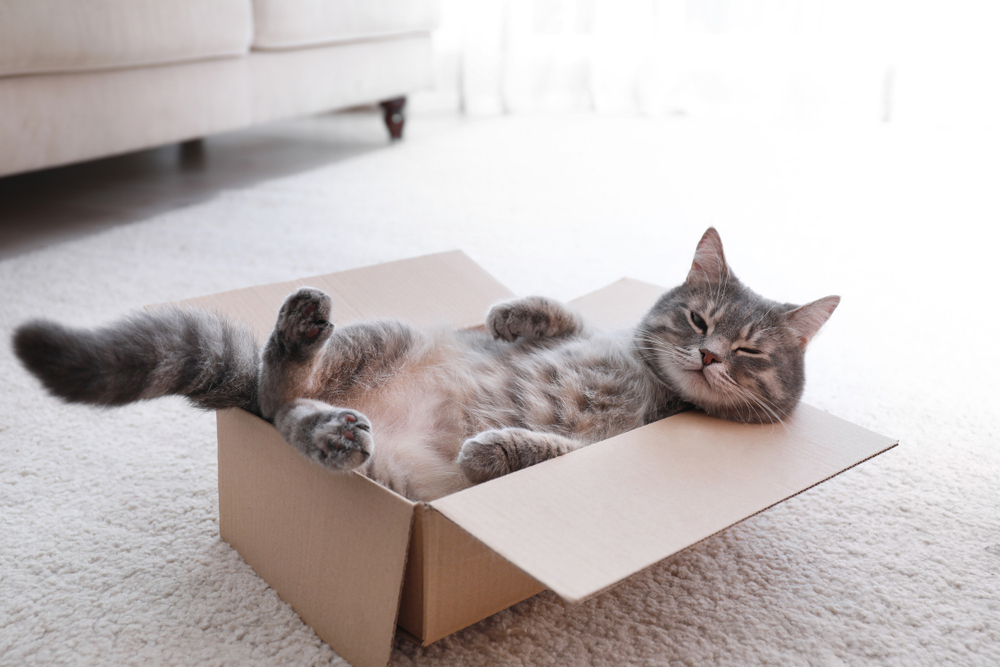

In [17]:
import requests

url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
image = Image.open(requests.get(url, stream=True).raw)
question = "What is unusual on this image?"

print(f"Question:\n{question}")
image

In [18]:
from transformers import TextStreamer

msgs = [{"role": "user", "content": question}]

streamer = TextStreamer(tokenizer=tokenizer, skip_special_tokens=True)

print("Answer:")
res, context, _ = model.chat(image=image, msgs=msgs, context=None, tokenizer=tokenizer, sampling=True, temperature=0.7, streamer=streamer)

Answer:


2024-07-10 08:42:06.593801: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 08:42:06.595542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 08:42:06.629032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 08:42:07.291644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The unusual aspect of this image is the presence of a cat lying inside an open cardboard box on what appears to be carpeted floor.


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [25]:
import gradio as gr
import traceback
import re
from transformers import TextIteratorStreamer
from threading import Thread


ERROR_MSG = "Error, please retry"
model_name = "MiniCPM-V 2.0"

form_radio = {"choices": ["Beam Search", "Sampling"], "value": "Sampling", "interactive": True, "label": "Decode Type"}
# Beam Form
num_beams_slider = {"minimum": 0, "maximum": 5, "value": 3, "step": 1, "interactive": True, "label": "Num Beams"}
repetition_penalty_slider = {"minimum": 0, "maximum": 3, "value": 1.2, "step": 0.01, "interactive": True, "label": "Repetition Penalty"}
repetition_penalty_slider2 = {"minimum": 0, "maximum": 3, "value": 1.05, "step": 0.01, "interactive": True, "label": "Repetition Penalty"}
max_new_tokens_slider = {"minimum": 1, "maximum": 4096, "value": 1024, "step": 1, "interactive": True, "label": "Max New Tokens"}

top_p_slider = {"minimum": 0, "maximum": 1, "value": 0.8, "step": 0.05, "interactive": True, "label": "Top P"}
top_k_slider = {"minimum": 0, "maximum": 200, "value": 100, "step": 1, "interactive": True, "label": "Top K"}
temperature_slider = {"minimum": 0, "maximum": 2, "value": 0.7, "step": 0.05, "interactive": True, "label": "Temperature"}


def create_component(params, comp="Slider"):
    if comp == "Slider":
        return gr.Slider(
            minimum=params["minimum"],
            maximum=params["maximum"],
            value=params["value"],
            step=params["step"],
            interactive=params["interactive"],
            label=params["label"],
        )
    elif comp == "Radio":
        return gr.Radio(choices=params["choices"], value=params["value"], interactive=params["interactive"], label=params["label"])
    elif comp == "Button":
        return gr.Button(value=params["value"], interactive=True)


def chat(img, msgs, ctx, params=None, vision_hidden_states=None):
    default_params = {"num_beams": 3, "repetition_penalty": 1.2, "max_new_tokens": 1024}
    if params is None:
        params = default_params
    if img is None:
        return -1, "Error, invalid image, please upload a new image", None, None
    try:
        image = img.convert("RGB")
        streamer = TextIteratorStreamer(tokenizer, **{"skip_special_tokens": True})
        generation_params = {"image": image, "msgs": msgs, "context": None, "tokenizer": tokenizer, "streamer": streamer, **params}
        thread = Thread(target=model.chat, kwargs=generation_params)
        thread.start()

        buffer = ""

        for res in streamer:
            res = re.sub(r"(<box>.*</box>)", "", res)
            res = res.replace("<ref>", "")
            res = res.replace("</ref>", "")
            res = res.replace("<box>", "")
            new_text = res.replace("</box>", "")
            buffer += new_text
            yield -1, buffer, None, None
    except Exception as err:
        print(err)
        traceback.print_exc()
        return -1, ERROR_MSG, None, None


def upload_img(image, _chatbot, _app_session):
    image = Image.fromarray(image)

    _app_session["sts"] = None
    _app_session["ctx"] = []
    _app_session["img"] = image
    _chatbot.append(("", "Image uploaded successfully, you can talk to me now"))
    return _chatbot, _app_session


def respond(_question, _chat_bot, _app_cfg, params_form, num_beams, repetition_penalty, repetition_penalty_2, top_p, top_k, temperature):
    if _app_cfg.get("ctx", None) is None:
        _chat_bot.append((_question, "Please upload an image to start"))
        return "", _chat_bot, _app_cfg

    _context = _app_cfg["ctx"].copy()
    if _context:
        _context.append({"role": "user", "content": _question})
    else:
        _context = [{"role": "user", "content": _question}]

    if params_form == "Beam Search":
        params = {"sampling": False, "num_beams": num_beams, "repetition_penalty": repetition_penalty, "max_new_tokens": 896}
    else:
        params = {
            "sampling": True,
            "top_p": top_p,
            "top_k": top_k,
            "temperature": temperature,
            "repetition_penalty": repetition_penalty_2,
            "max_new_tokens": 896,
        }

    _context.append({"role": "assistant", "content": ""})
    _chat_bot.append([_question, ""])
    for code, _answer, _, sts in chat(_app_cfg["img"], _context, None, params):
        _context[-1]["content"] = _answer
        _chat_bot[-1][-1] = _answer

        if code == 0:
            _app_cfg["ctx"] = _context
            _app_cfg["sts"] = sts
        yield "", _chat_bot, _app_cfg


def regenerate_button_clicked(_question, _chat_bot, _app_cfg, params_form, num_beams, repetition_penalty, repetition_penalty_2, top_p, top_k, temperature):
    if len(_chat_bot) <= 1:
        _chat_bot.append(("Regenerate", "No question for regeneration."))
        return "", _chat_bot, _app_cfg
    elif _chat_bot[-1][0] == "Regenerate":
        return "", _chat_bot, _app_cfg
    else:
        _question = _chat_bot[-1][0]
        _chat_bot = _chat_bot[:-1]
        _app_cfg["ctx"] = _app_cfg["ctx"][:-2]
    for text, _chatbot, _app_cfg in respond(
        _question, _chat_bot, _app_cfg, params_form, num_beams, repetition_penalty, repetition_penalty_2, top_p, top_k, temperature
    ):
        yield text, _chatbot, _app_cfg


with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=1, min_width=300):
            params_form = create_component(form_radio, comp="Radio")
            with gr.Accordion("Beam Search") as beams_according:
                num_beams = create_component(num_beams_slider)
                repetition_penalty = create_component(repetition_penalty_slider)
            with gr.Accordion("Sampling") as sampling_according:
                top_p = create_component(top_p_slider)
                top_k = create_component(top_k_slider)
                temperature = create_component(temperature_slider)
                repetition_penalty_2 = create_component(repetition_penalty_slider2)
            regenerate = create_component({"value": "Regenerate"}, comp="Button")
        with gr.Column(scale=3, min_width=500):
            app_session = gr.State({"sts": None, "ctx": None, "img": None})
            bt_pic = gr.Image(label="Upload an image to start")
            chat_bot = gr.Chatbot(label=f"Chat with {model_name}")
            txt_message = gr.Textbox(label="Input text")

            regenerate.click(
                regenerate_button_clicked,
                [txt_message, chat_bot, app_session, params_form, num_beams, repetition_penalty, repetition_penalty_2, top_p, top_k, temperature],
                [txt_message, chat_bot, app_session],
            )
            txt_message.submit(
                respond,
                [txt_message, chat_bot, app_session, params_form, num_beams, repetition_penalty, repetition_penalty_2, top_p, top_k, temperature],
                [txt_message, chat_bot, app_session],
            )
            bt_pic.upload(lambda: None, None, chat_bot, queue=False).then(upload_img, inputs=[bt_pic, chat_bot, app_session], outputs=[chat_bot, app_session])


try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/